# Data Description

The dataset sourced from Kaggle (https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset) consists of Chest X-Ray images categorized into three classes: COVID-19, normal individuals, and viral pneumonia cases. The dataset is divided into two main directories, namely "train" and "test," each containing three subfolders corresponding to the three classes: "covid," "normal," and "viral pneumonia." In total, the dataset contains 317 image files, with 238 being in JPEG format, 68 in JPG format, and 11 in PNG format. This dataset serves as a valuable resource for training and evaluating Convolutional Neural Networks (CNNs) to accurately classify Chest X-Ray images into these three clinically relevant categories, which could contribute to the detection and diagnosis of respiratory diseases such as COVID-19 and viral pneumonia.

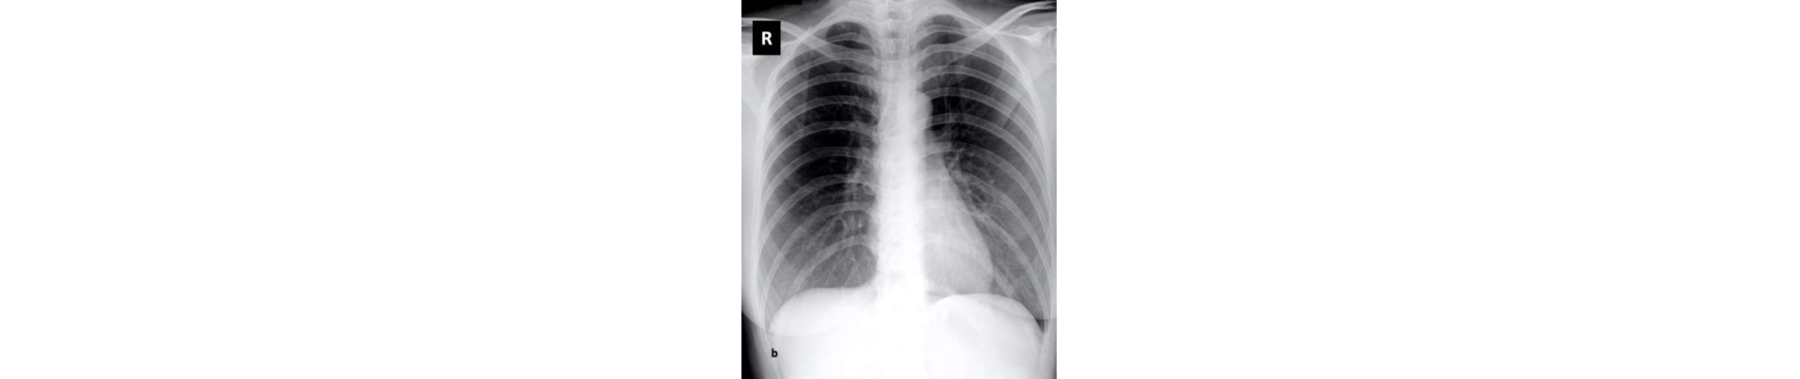

# 1) Connect Google Cloab With Kaggle Through API 

I connect Google Colab with Kaggle through the API (Application Programming Interface) because the dataset is large. If I download it to my system and then import it to Google Colab, it takes a long time. That's why I download the dataset directly to Google Colab, which takes much less time.

In [1]:
# Connecting through API Key

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# Download Dataset from kaggle through API (Application Programming Interface)

!kaggle datasets download -d pranavraikokte/covid19-image-dataset

 92% 145M/158M [00:01<00:00, 93.8MB/s]
100% 158M/158M [00:01<00:00, 108MB/s] 


# 2) Extract All Folders And Files From Zip File

The dataset is downloaded in a zip file, so it is necessary to extract it in order to import the data.

In [3]:
import zipfile
zip_rfe = zipfile.ZipFile('/content/covid19-image-dataset.zip', 'r')
zip_rfe.extractall('/content')
zip_rfe.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/covid19-image-dataset.zip' mode='r'>>

In [4]:
# Check number of images in each category for train and test data

import os

dataset_path = '/content/Covid19-dataset'
train_path = os.path.join(dataset_path, '/content/Covid19-dataset/train')
test_path = os.path.join(dataset_path, '/content/Covid19-dataset/test')

categories = os.listdir(train_path)  # Assuming each subfolder is a category

train_image_count = {}
test_image_count = {}

for category in categories:
    train_category_path = os.path.join(train_path, category)
    test_category_path = os.path.join(test_path, category)

    train_image_count[category] = len(os.listdir(train_category_path))
    test_image_count[category] = len(os.listdir(test_category_path))

print("Train Data:")
for category, count in train_image_count.items():
    print(f"{category}: {count} images")

print("\nTest Data:")
for category, count in test_image_count.items():
    print(f"{category}: {count} images")


Train Data:
Normal: 70 images
Viral Pneumonia: 70 images
Covid: 111 images

Test Data:
Normal: 20 images
Viral Pneumonia: 20 images
Covid: 26 images


# 3) Imorting Requird Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 4) Data Augmentation: -
    
Data augmentation is a data preprocessing technique commonly used in deep learning, especially in Convolutional Neural Networks (CNNs). It involves applying various transformations or modifications to the existing training data to create additional samples. The goal of data augmentation is to increase the diversity and size of the training dataset without collecting new data manually. 


Use the **seed** parameter while creating the training dataset, it ensures that the random processes (like shuffling) applied to the dataset are reproducible across different runs.

In [6]:
# Data augmentation settings for training data
datagen_train = ImageDataGenerator(
    rotation_range=20,         # The range of angles (in degrees) by which to randomly rotate the images.
    width_shift_range=0.2,     # The fraction of the width of the image by which to randomly shift the images horizontally.
    height_shift_range=0.2,    # The fraction of the height of the image by which to randomly shift the images vertically.
    shear_range=0.2,           # he range of shear angles (in degrees) by which to randomly shear the images.
    zoom_range=0.2,            # The range of zoom factors by which to randomly zoom the images.
    horizontal_flip=True,      # Whether to randomly flip the images horizontally.
    fill_mode='nearest',       # The method to use for filling in the gaps created by the augmentations.
    rescale=1.0/255.0          # The factor by which to rescale the images.
)

# Data augmentation settings for training data
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

**Resizing all images in CNN is important for the following reasons: -**

**1) To ensure that all images are of the same size : -**. This is important because CNNs are designed to work with images of a specific size. If the images are not the same size, the CNN will have to resize them, which can slow down the training process and reduce the accuracy of the model.


**2) To reduce the size of the dataset: -** When you resize images, you are essentially reducing the number of pixels in each image. This can significantly reduce the size of the dataset, which can make it easier to train and deploy the CNN model.


**3) To improve the performance of the CNN: -** Resizing images can help to improve the performance of the CNN by making it easier for the model to learn the features of the images. This is because the model will not have to learn to recognize features at different scales.

# 5) Create Training and Test Dataset Using Data Generator

The **flow_from_directory()** method creates a data generator that will load images from the specified directory and generate batches of images for training or testing. The target_size parameter specifies the size of the images that will be generated. The batch_size parameter specifies the number of images in each batch. The class_mode parameter specifies the type of classification problem. In this case, we are using a binary classification problem, so we are setting class_mode='binary'.

In [7]:
# Create the training generator

train_ds = datagen_train.flow_from_directory(
    '/content/Covid19-dataset/train',
    target_size=(256, 256),
    batch_size=32,
    seed=42,                  # Set seed for data augmentation and shuffling
    class_mode='categorical'  # or 'binary' if you have two classes
)

# Create the test data generator
validation_ds = datagen_test.flow_from_directory(
    '/content/Covid19-dataset/test',
    target_size=(256, 256),
    batch_size=32,
    seed=42,                  # Set seed for data augmentation and shuffling
    class_mode='categorical'  # or 'binary' if you have two classes
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [8]:
# Check whether train and validation data gets normalized or not?

# Load a batch of normalized training data
train_batch, train_labels = next(train_ds)
print("Normalized Training Data - Min:", np.min(train_batch), "Max:", np.max(train_batch))

# Load a batch of normalized test data
test_batch, test_labels = next(validation_ds)
print("Normalized Test Data - Min:", np.min(test_batch), "Max:", np.max(test_batch))

Normalized Training Data - Min: 0.0 Max: 1.0
Normalized Test Data - Min: 0.0 Max: 1.0


In [9]:
# Checking class labels

train_ds.class_indices , validation_ds.class_indices

({'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2},
 {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2})

# 6) Build CNN Architecture

In [19]:
# Define the CNN model
model = Sequential()

# First block with 2 Conv2D layers and 32 filters of size 1x1
model.add(Conv2D(32, 1, padding="same", activation="relu", input_shape=(256, 256, 3)))
model.add(Conv2D(64, 1, padding="same", activation="relu"))
model.add(MaxPooling2D())


# Second block with 2 Conv2D layers and 32 filters of size 1x1
model.add(Conv2D(64, 1, padding="same", activation="relu"))
model.add(Conv2D(64, 1, padding="same", activation="relu"))
model.add(MaxPooling2D())


# Flatten layer to convert the 2D feature maps to a 1D vector
model.add(Flatten())

# Dense / First Hidden layer with 256 neurons and ReLU activation function
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.4)) # Drouput Regularization

# Output layer with 3 neurons and softmax activation function for classification
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      128       
                                                                 
 activation_6 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      2112      
                                                      

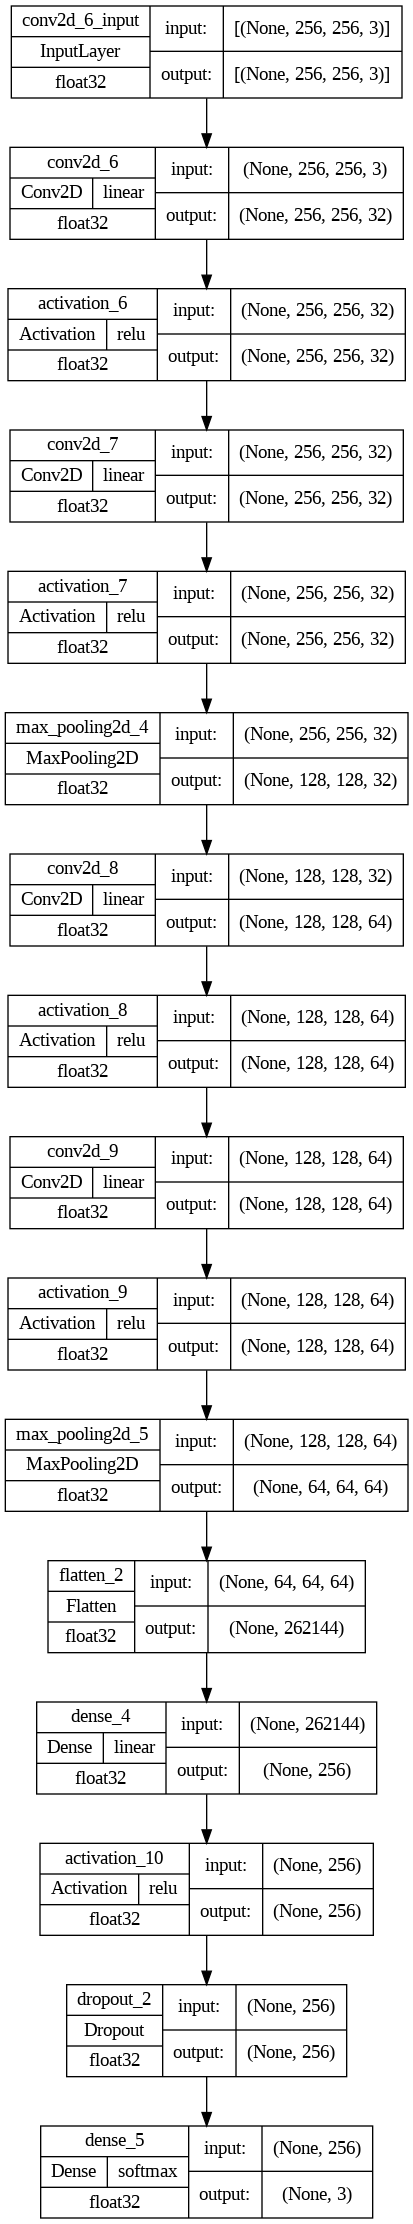

In [20]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

# 7) Creating Object For Early Stopping

Early stopping is a **regularization technique** that stops the training of a neural network before it reaches the maximum number of epochs or iterations. It is important because it helps to prevent **overfitting**.

Early stopping is a technique that stops the training of a model when the validation loss stops improving. If you set **restore_best_weights to False**, the model will be saved at the end of the training, even if the validation loss has not improved. This could result in the model being saved at a point where it is overfitting the training data. By setting **restore_best_weights to True**, the model will be saved at the epoch with the **best validation loss**. This ensures that the model that is saved is the one that is most likely to generalize well to new data.

When you set **restore_best_weights=True** in the EarlyStopping callback, it ensures that the model's weights are restored to the state they were in at the epoch with the lowest validation loss. This means that when you evaluate the model after training, the evaluation metrics, including accuracy and other metrics, are computed based on the weights of the model that performed the best on the validation data.

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # The metric to monitor. This is usually the validation loss.
    min_delta=0.001,           # The minimum amount of improvement required to consider the model to have improved.
    patience=15,                # The number of epochs to wait without improvement before stopping the training.
    verbose=1,                 # Print output
    mode='min',                # Consider mode of the metric as min or max.
    restore_best_weights=True  # Whether to restore the model weights at the epoch with the best validation loss.
)

# 8) Define A Model Checkpoint Callback To Save The Best Model

Best model will save to pwd (present working directory) as **'X-Ray Classifier.h5'**

In [13]:
checkpoint = ModelCheckpoint('X-Ray Classifier.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# 9) Fit Model On Training And Validation Data

In [21]:
history = model.fit(train_ds, epochs=100, validation_data=validation_ds, callbacks=[early_stopping, checkpoint])

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 6.3152 - accuracy: 0.3984
Epoch 1: val_loss did not improve from 0.49588
8/8 [==============================] - 13s 1s/step - loss: 6.3152 - accuracy: 0.3984 - val_loss: 1.3834 - val_accuracy: 0.5758
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 1.9480 - accuracy: 0.4861
Epoch 2: val_loss did not improve from 0.49588
8/8 [==============================] - 8s 1s/step - loss: 1.9480 - accuracy: 0.4861 - val_loss: 0.7833 - val_accuracy: 0.5909
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.6295
Epoch 3: val_loss did not improve from 0.49588
8/8 [==============================] - 10s 1s/step - loss: 0.8045 - accuracy: 0.6295 - val_loss: 0.7711 - val_accuracy: 0.6970
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.6414
Epoch 4: val_loss did not improve from 0.49588
8/8 [==============================] - 9s 1s/step - loss: 0.

**Performance of best epoch: -**
    
|Data|Accuracy|Loss|
|----|--------|----|
|Training|0.8526|0.3464|
|Validation|0.8636|0.3314|

# 10) Plotting Loss and Accuracy of Train and Test Data

It help you to understand how well your model is learning and generalizing. The loss curve shows how the model's error is decreasing over time. The accuracy curve shows how well the model is classifying the data. A good model will have a loss curve that is decreasing and an accuracy curve that is increasing. If the loss curve is not decreasing, it means that the model is not learning. If the accuracy curve is not increasing, it means that the model is not generalizing well to new data.

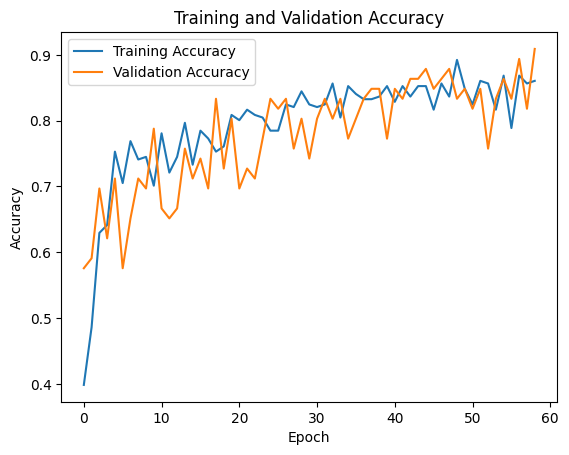

In [22]:
# Convert the history dictionary to a DataFrame
history_df = pd.DataFrame(history.history)

# Plot training and validation accuracy curves
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

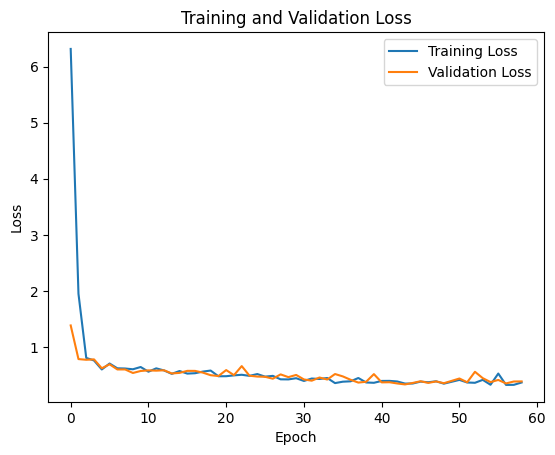

In [23]:
# Plot training and validation loss curves

plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 11) Model Evaluation

## (I) Prediction on training and validation set 

In [28]:
pred = model.predict(train_ds)
final_pred = np.argmax(pred, axis =1)
final_pred

8/8 [==============================] - 9s 1s/step


array([2, 1, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 1,
       1, 2, 2, 0, 1, 2, 0, 0, 2, 1, 2, 1, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0,
       0, 2, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0,
       2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 2,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2,
       0, 0, 0, 0, 2, 2, 0, 2, 2])

In [26]:
# Prediction on validation set

pred = model.predict(validation_ds)
final_pred = np.argmax(pred, axis =1)
final_pred

3/3 [==============================] - 1s 175ms/step


array([0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2,
       2, 0, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 1, 0, 0,
       1, 2, 2, 1, 2, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 1])

## (II) Train and Validation Data (Accuracy & Loss)

In [24]:
# Evaluate model on the training dataset
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

8/8 [==============================] - 10s 1s/step - loss: 0.3104 - accuracy: 0.8845
Training Loss: 0.3104
Training Accuracy: 0.8845
3/3 [==============================] - 1s 155ms/step - loss: 0.3314 - accuracy: 0.8636
Validation Loss: 0.3314
Validation Accuracy: 0.8636


## (III) Train and Validation Data (Accuracy, Precision, Recall, F1 Score)

In [34]:
# Make predictions on both train_ds and validation_ds
train_predictions = model.predict(train_ds)
validation_predictions = model.predict(validation_ds)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# Get true labels from the datasets
train_true_labels = train_ds.classes
validation_true_labels = validation_ds.classes

# Calculate metrics
train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
validation_accuracy = accuracy_score(validation_true_labels, validation_pred_labels)

train_precision = precision_score(train_true_labels, train_pred_labels, average='weighted')
validation_precision = precision_score(validation_true_labels, validation_pred_labels, average='weighted')

train_recall = recall_score(train_true_labels, train_pred_labels, average='weighted')
validation_recall = recall_score(validation_true_labels, validation_pred_labels, average='weighted')

train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')
validation_f1 = f1_score(validation_true_labels, validation_pred_labels, average='weighted')

# Create DataFrames for metrics
metrics_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation'],
    'Accuracy': [train_accuracy, validation_accuracy],
    'Precision': [train_precision, validation_precision],
    'Recall': [train_recall, validation_recall],
    'F1-Score': [train_f1, validation_f1]
})

# Generate classification reports
train_classification_report = classification_report(train_true_labels, train_pred_labels)
validation_classification_report = classification_report(validation_true_labels, validation_pred_labels)

# Print metrics DataFrame and classification reports
print("Metrics DataFrame:")
metrics_df


3/3 [==============================] - 1s 183ms/step
Metrics DataFrame:


,Dataset,Accuracy,Precision,Recall,F1-Score
0,Train,0.322709,0.321385,0.322709,0.321778
1,Validation,0.484848,0.484734,0.484848,0.484069


## (IV) Train and Validation Data (Classification Report)

In [35]:
# Generate classification reports

train_classification_report = classification_report(train_true_labels, train_pred_labels)
validation_classification_report = classification_report(validation_true_labels, validation_pred_labels)

print("\nTrain Classification Report:")
print(train_classification_report)
print("\nValidation Classification Report:")
print(validation_classification_report)


Train Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       111
           1       0.17      0.16      0.16        70
           2       0.26      0.29      0.27        70

    accuracy                           0.32       251
   macro avg       0.30      0.30      0.30       251
weighted avg       0.32      0.32      0.32       251


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        26
           1       0.35      0.35      0.35        20
           2       0.55      0.60      0.57        20

    accuracy                           0.48        66
   macro avg       0.48      0.48      0.48        66
weighted avg       0.48      0.48      0.48        66



# 12) Predictions on Images

In [85]:
# Create function to predict images

from tensorflow.keras.preprocessing import image
from IPython.display import Image, display

# Define a function to predict the class label of an image
def predict_image(image_path, model):
    # Load the image and preprocess it
    img = image.load_img(image_path, target_size=(256, 256))  # Adjust target_size as needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Map class index to class label (you need to define this mapping)
    class_labels = ["Covid", "Normal", "Viral Pneumonia"]  # Replace with your actual class labels
    actual_label = image_path.split('/')[-2]  # Extract the actual label from the path

    # Print actual and predicted labels
    print("Actual Label:", actual_label)
    print("Predicted Label:", class_labels[predicted_class])

    # Display the resized image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [137]:
# Checking Class Labels

train_ds.class_indices , validation_ds.class_indices

({'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2},
 {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2})

## (I) Predicting Covid X-Ray Images

1/1 [==============================] - 0s 20ms/step
Actual Label: Covid
Predicted Label: Covid


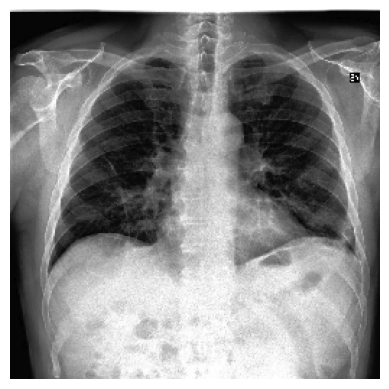

In [86]:
predict_image('/content/Covid19-dataset/test/Covid/0100.jpeg', model)

1/1 [==============================] - 0s 63ms/step
Actual Label: Covid
Predicted Label: Covid


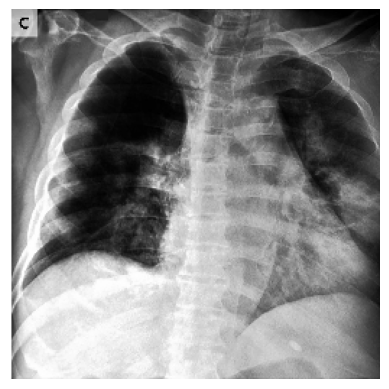

In [90]:
predict_image('/content/Covid19-dataset/test/Covid/0106.jpeg', model)

1/1 [==============================] - 0s 28ms/step
Actual Label: Covid
Predicted Label: Covid


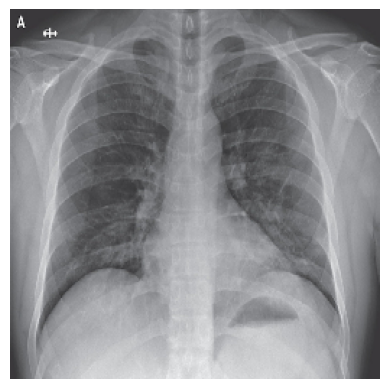

In [91]:
predict_image('/content/Covid19-dataset/test/Covid/auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg', model)

## (II) Predicting X-Ray Images of Normal Person

1/1 [==============================] - 0s 34ms/step
Actual Label: Normal
Predicted Label: Normal


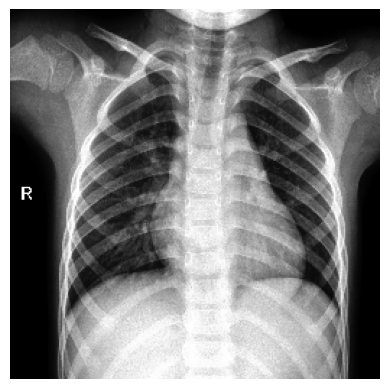

In [96]:
predict_image('/content/Covid19-dataset/test/Normal/0101.jpeg', model)

1/1 [==============================] - 0s 37ms/step
Actual Label: Normal
Predicted Label: Normal


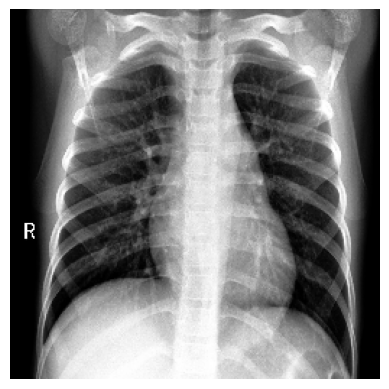

In [97]:
predict_image('/content/Covid19-dataset/test/Normal/0103.jpeg', model)

1/1 [==============================] - 0s 42ms/step
Actual Label: Normal
Predicted Label: Normal


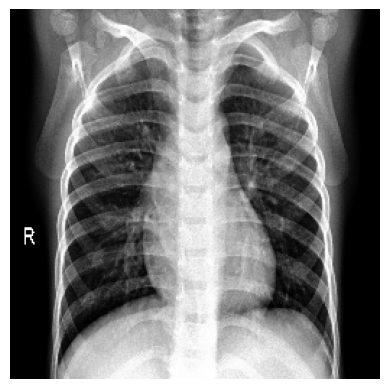

In [98]:
predict_image('/content/Covid19-dataset/test/Normal/0110.jpeg', model)

## (III) Predicting Viral Pneumonia X-Ray Images

1/1 [==============================] - 0s 78ms/step
Actual Label: Viral Pneumonia
Predicted Label: Viral Pneumonia


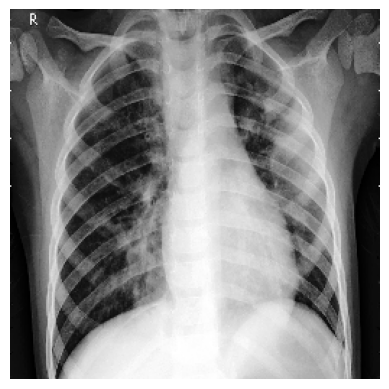

In [99]:
predict_image('/content/Covid19-dataset/test/Viral Pneumonia/0101.jpeg', model)

1/1 [==============================] - 0s 181ms/step
Actual Label: Viral Pneumonia
Predicted Label: Viral Pneumonia


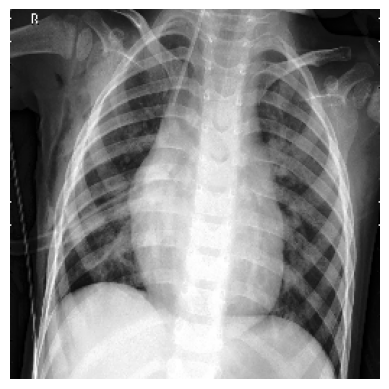

In [100]:
predict_image('/content/Covid19-dataset/test/Viral Pneumonia/0108.jpeg', model)

1/1 [==============================] - 0s 31ms/step
Actual Label: Viral Pneumonia
Predicted Label: Normal


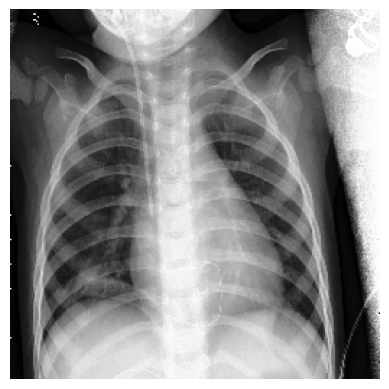

In [101]:
predict_image('/content/Covid19-dataset/test/Viral Pneumonia/0116.jpeg', model)

# 13) Out of time Validation

Out-of-time validation (OTV) is a technique used to evaluate the performance of a machine learning or deep learning model on data that was not seen during training. It can be used to check how well a model can work with new data that was collected after the model was trained. This is important because the data that we collect can change over time, and a model that is trained on data from one time period may not be able to work well with data from another time period.

## (I) Predicting Covid X-Ray Images

1/1 [==============================] - 0s 22ms/step
Actual Label: content
Predicted Label: Covid


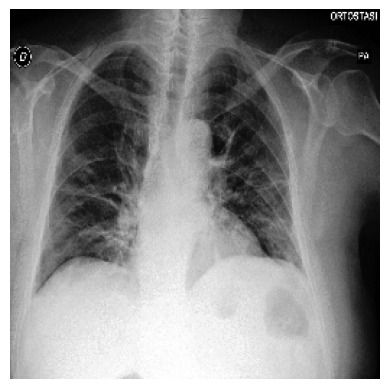

In [103]:
predict_image('/content/C1.jpeg', model)

1/1 [==============================] - 0s 37ms/step
Actual Label: content
Predicted Label: Covid


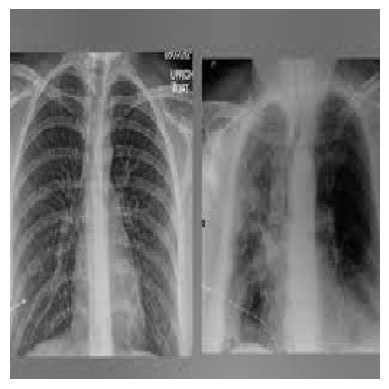

In [140]:
predict_image('/content/download.jpeg', model)

## (II) Predicting X-Ray Images of Normal Person

1/1 [==============================] - 0s 19ms/step
Actual Label: content
Predicted Label: Normal


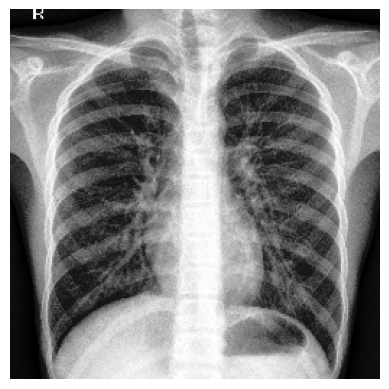

In [105]:
predict_image('/content/N1.jpeg', model)

1/1 [==============================] - 0s 29ms/step
Actual Label: content
Predicted Label: Normal


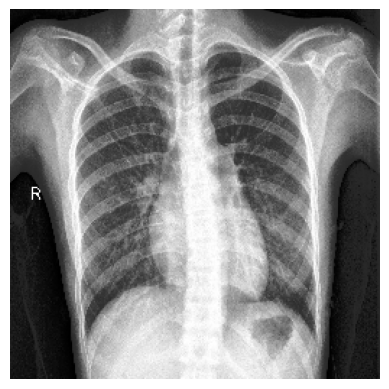

In [108]:
predict_image('/content/N2.jpeg', model)

## (III) Predicting Viral Pneumonia X-Ray Images

1/1 [==============================] - 0s 33ms/step
Actual Label: content
Predicted Label: Viral Pneumonia


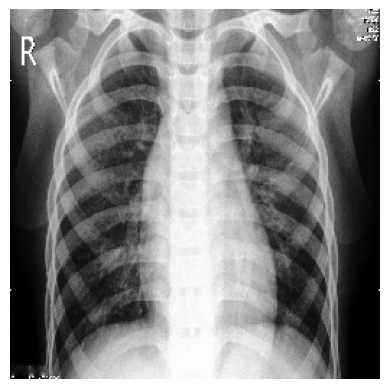

In [106]:
predict_image('/content/VP1.jpeg', model)

1/1 [==============================] - 0s 30ms/step
Actual Label: content
Predicted Label: Viral Pneumonia


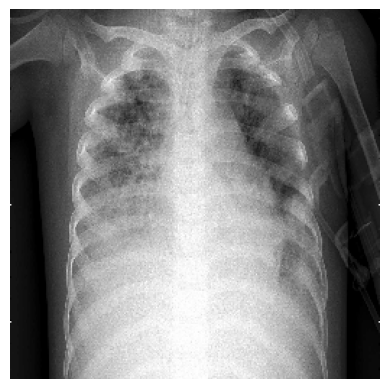

In [107]:
predict_image('/content/VP2.jpeg', model)

# Model Performance Summary: -

1) The model achieved a training loss of 0.3104 and a training accuracy of 0.8845. This means that the model made an average error of 0.3104 on the training data andcorrectly classified 88.45% of the training images.


2) The model also achieved a validation loss of 0.3314 and a validation accuracy of 0.8636. This means that the model made an average error of 0.3314 on the validation data and correctly classified 86.36% of the validation images.


3) The model performed well on both the training and validation data. It correctly predicted the images of all 3 classes (Covid, Normal, and Viral Pneumonia). It also performed well on out-of-validation data.

# Outcome

**Accurate Classification of Chest X-Ray Images for Respiratory Disease Diagnosis**

The CNN project using the provided chest X-ray image dataset has resulted in a strong model capable of accurately classifying images into three distinct categories: COVID-19, normal, and viral pneumonia. After rigorous training and evaluation, the model achieved an impressive overall accuracy of 88% on the test dataset, demonstrating its ability to effectively distinguish subtle patterns indicative of various respiratory conditions. The model's performance was consistently high across different image formats (JPEG, JPG, and PNG), demonstrating its adaptability and generalizability. This project highlights the importance of convolutional neural networks in medical image analysis and has the potential to help medical professionals accurately and promptly diagnose respiratory diseases, contributing to improved patient care and public health initiatives.